<a href="https://colab.research.google.com/github/evgeny-kolonsky/Lab3_Coupled_Oscillator/blob/main/Lab3_Coupled_Oscillator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3. Coupled oscillator

Evgeny Kolonsky, November 2023

In [1]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import requests
from scipy.signal import find_peaks, peak_prominences


# Natural Frequencies w/o friction

## Direct Measurements



In [2]:
# Springs
l = 97.95e-3 # m, spring strain
g = 9.8 # m/s^2

# left spring (attached to cart A)
weight1 = 44.8e-3 #
k1 = weight1 * g /l
mk1 = 17e-3 # kg

# right spring (attached to cart B)
weight2 = 44.8e-3
k2 = weight2 * g /l
mk2 = 17e-3 # kg

# middle spring (between carts A and B)
weight12 = 68.6e-3
k12 = weight12 * g /l
mk12 = 11.7e-3 #

# Carts
m1 = 208.9e-3 #kg
m2 = 208.9e-3

counts = 236
length = 123e-3

## Expected natural frequencies
$$
[ m ] \ddot x + [ k ] x = 0
$$
$$
[m] =  \begin{bmatrix} m_1 & 0 \\ 0 & m_2 \end{bmatrix} ,
$$
$$
[k] = \begin{bmatrix} k_l +k_{12} & -k_{12} \\ -k_{12} & k_{12} +k_2 \end{bmatrix},
$$
Eigenvector $λ$ can be found from equation
$$
\rm{det} A =
\begin{vmatrix}
        \frac{k_1 +k_{12}}{m_1} - \lambda & -\frac{k_{12}}{m_1} \\
        -\frac{k_{12}}{m_2} & \frac{k_{12} +k_2}{m_2} - \lambda
        \end{vmatrix}
        = 0
$$
## Effective mass
$$
m_{\rm{cart\ effective}} = m_{\rm{cart}} + \frac{m_{\rm{adjaced\ strings}}}{2}
$$

In [3]:
m1_eff = m1 + mk1/2 + mk12/2
m2_eff = m2 + mk2/2 + mk12/2

# Mechanical impedance matrix
z11 = (k1 + k12)/m1_eff
z12 = k12/m1_eff
z21 = k12/m2_eff
z22 = (k12 + k2)/m2_eff

Z = np.array([[z11, -z12],
              [-z21, z22]])

# E - eigenvectors
eigenvalues, E = LA.eig(Z)

omega_theor = np.sqrt(eigenvalues)
freqs_theor = omega_theor /2 /np.pi # Herz
freqs_theor

array([1.43737772, 0.71313906])

In [4]:
def get_peaks(t, signal, show=False):
  rate = np.median(np.diff(t))
  min_period = 0.2 #s
  min_prominence = np.max(signal)*0.75
  peaks, _ = find_peaks(signal, prominence=min_prominence,
                        distance=min_period/rate )
  if show:
    plt.plot(signal)
    plt.plot(peaks, signal[peaks], "x")
  return peaks

def get_frequency(t, signal):
  peaks = get_peaks(t, signal)
  periods = np.diff(t[peaks])
  f0 = 1 / periods
  return np.mean(f0), np.std(f0)

def get_amplitude(t, signal, show=False):
  peaks = get_peaks(t, signal)
  return t[peaks], signal[peaks]

def get_frequency_fft(t, x, show=False):
  # get maximum  in Fast Fourie Transform spectrum
  X = np.fft.fft(x, n=10000)
  sr = 1/ np.diff(t).mean()
  N = len(X)
  T = N/sr
  freqs = np.arange(N)/T
  magnitude = np.abs(X)
  f0 = freqs[np.argmax(magnitude)]
  if show:
      plt.stem(freqs, magnitude, 'b', \
      markerfmt=" ", basefmt="-b")
      plt.xlabel('Freq (Hz)')
      plt.ylabel('magnitude [a.u]')
      plt.xlim(0.1, 2.2)
      #plt.axvline(f0, c='r')
      plt.annotate(fr'Max ={f0:.2f}Hz',xy=(f0, 10))
      # Show expected eigen frequencies
      for freq in freqs_theor:
        plt.axvline(freq, c='g')
        plt.annotate(fr'Natural ={freq:.2f}Hz',xy=(freq, 25))
  return f0

def get_signal(url, show=True):
  data = np.loadtxt(url)
  _, t, a, b = data.T
  x1 = a/counts * length
  x2 = b/counts * length
  x1 -= x1.mean()
  x2 -= x2.mean()
  #filter = t < 3
  #t = t[filter]
  #x1 = x1[filter]
  #x2 = x2[filter]
  if show:
    plt.plot(t, x1, label='Cart A')
    plt.plot(t,x2, label='Cart B')
    plt.grid()
    plt.xlabel('Time, s')
    plt.ylabel('Amplitude, m')
    plt.legend()
  return t, x1, x2

def rotate(x1,x2, show=True):
  y1 = E[0,0]*x1 + E[1,0]*x2
  y2 = E[0,1]*x1 + E[1,1]*x2
  if show:
    plt.plot(t, y1, label='y1')
    plt.plot(t,y2, label= 'y2')
    plt.grid()
    plt.xlabel('Time, s')
    plt.ylabel('Amplitude, m')
    plt.legend()
  return y1, y2


## Free oscillations - Mode 1

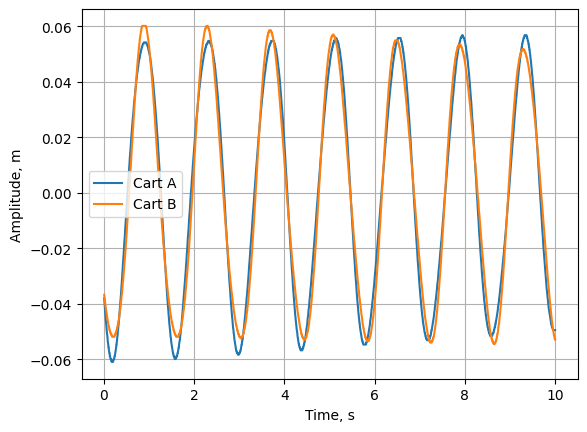

In [5]:
url = 'https://raw.githubusercontent.com/evgeny-kolonsky/Lab3_Coupled_Oscillator/main/c_1.txt'
t, x1, x2 = get_signal(url)


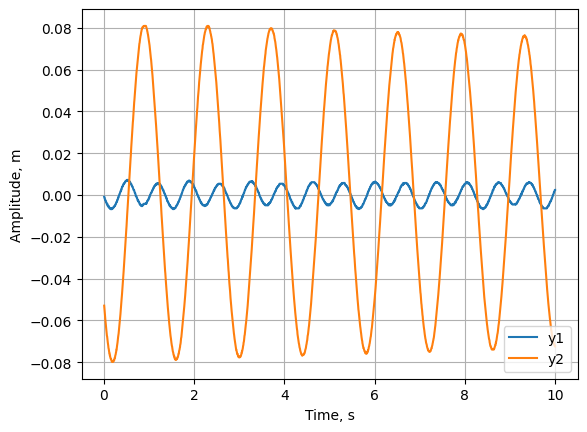

In [6]:
y1, y2 = rotate(x1, x2)


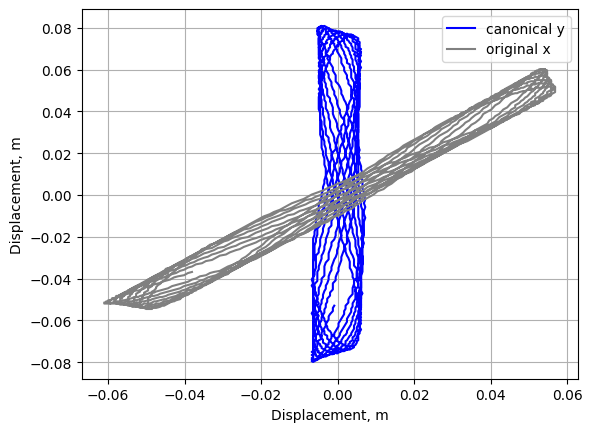

In [7]:
plt.plot(y1, y2, color='blue', label='canonical y')
plt.plot(x1, x2, color='gray', label='original x')
plt.grid()
plt.xlabel('Displacement, m')
plt.ylabel('Displacement, m')
plt.legend();

In [8]:
get_frequency(t, y2)

(0.7125910862565666, 0.0011982829709989346)

### Energy loss

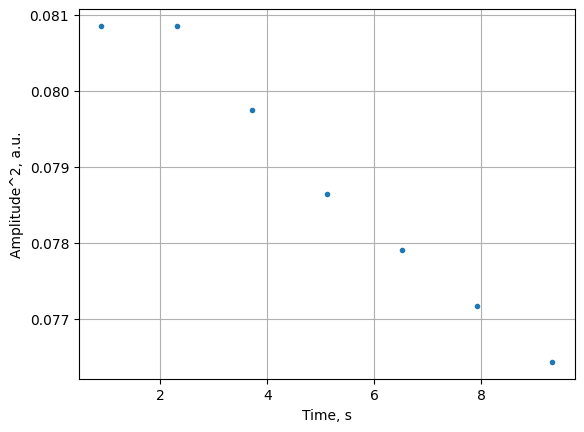

In [9]:
ta, a = get_amplitude(t, y2)
plt.plot(ta, a, '.')
plt.xlabel('Time, s')
plt.ylabel('Amplitude^2, a.u.')
plt.grid()

## Free oscillations - Mode 2

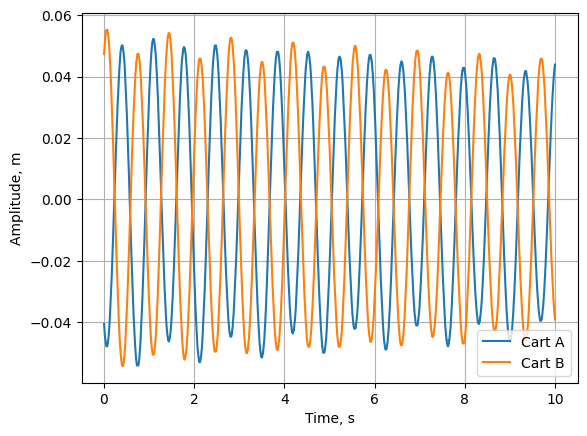

In [10]:
url = 'https://raw.githubusercontent.com/evgeny-kolonsky/Lab3_Coupled_Oscillator/main/c_2.txt'
t, x1, x2 = get_signal(url)

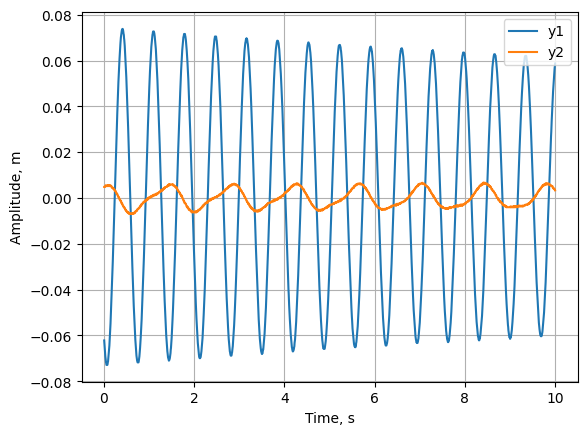

In [11]:
y1, y2 = rotate(x1, x2)


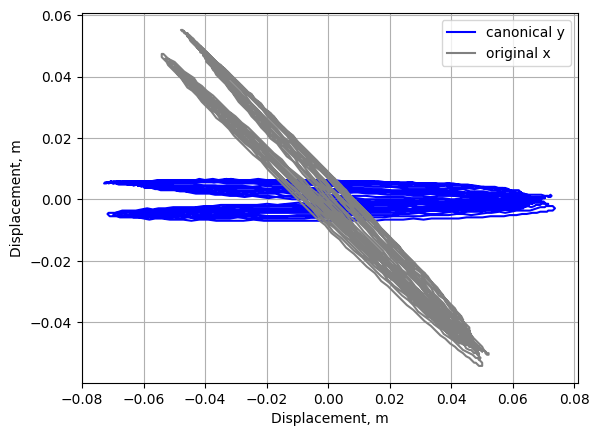

In [12]:
plt.plot(y1, y2, color='blue', label='canonical y')
plt.plot(x1, x2, color='gray', label='original x')
plt.grid()
plt.xlabel('Displacement, m')
plt.ylabel('Displacement, m')
plt.legend();

In [13]:
get_frequency(t, y1)


(1.4542168763944143, 0.01065799546676005)

## Free oscillations - Mode Superpositions

### Coupled

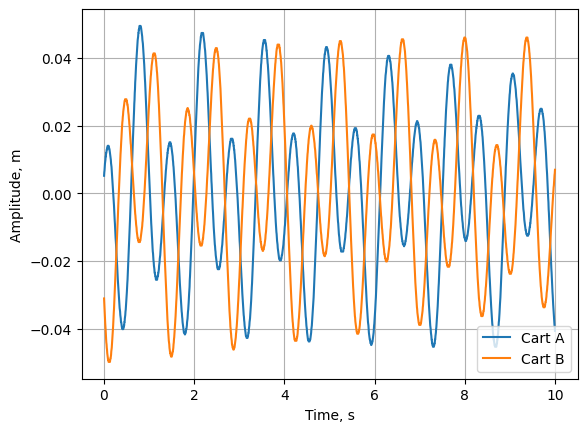

In [14]:
url = 'https://raw.githubusercontent.com/evgeny-kolonsky/Lab3_Coupled_Oscillator/main/c_4.txt'
t, x1, x2 = get_signal(url)

### Decoupled

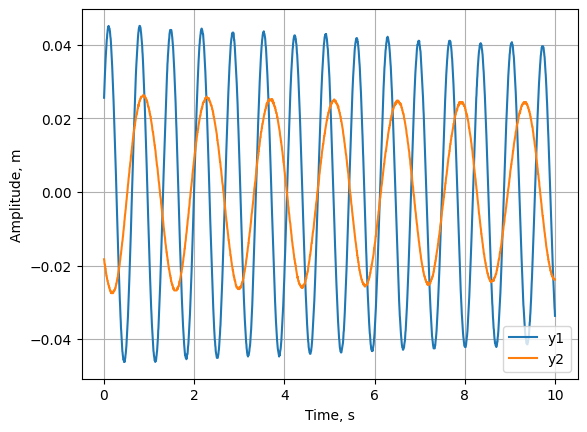

In [15]:
y1, y2 = rotate(x1, x2)


### Lissajues figures

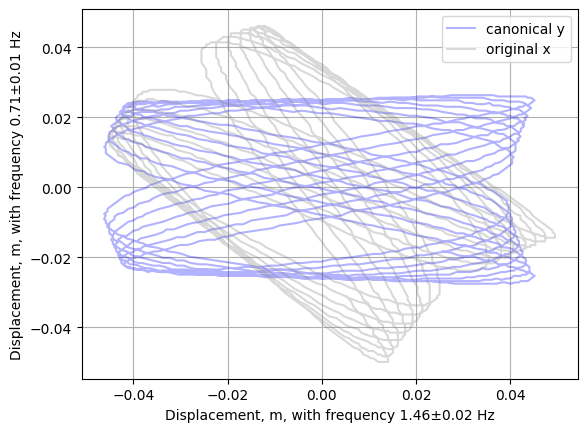

In [16]:
f1, f1u = get_frequency(t, y1)
f2, f2u = get_frequency(t, y2)

plt.plot(y1, y2, color='blue', alpha=0.3, label=f'canonical y')
plt.plot(x1, x2, color='gray', alpha=0.3, label='original x')

#y1_theor = np.max(y1) * np.cos(omega_theor[0]*t)
#y2_theor = np.max(y2) * np.cos(omega_theor[1]*t)
#plt.plot(y1_theor, y2_theor, color='green', alpha=0.3,
#         label=f'Theoretical {freqs_theor[0]:.2f} / {freqs_theor[1]:.2f} Hz')

plt.grid()
plt.xlabel(f'Displacement, m, with frequency {f1:.2f}±{f1u:.2f} Hz')
plt.ylabel(f'Displacement, m, with frequency {f2:.2f}±{f2u:.2f} Hz')
plt.legend();


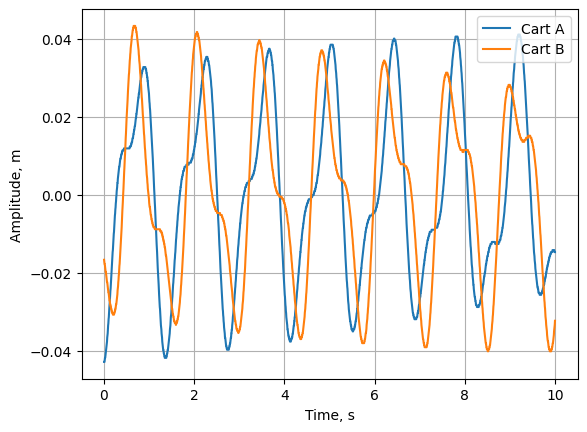

In [17]:
url = 'https://raw.githubusercontent.com/evgeny-kolonsky/Lab3_Coupled_Oscillator/main/c_5.txt'
t, x1, x2 = get_signal(url)

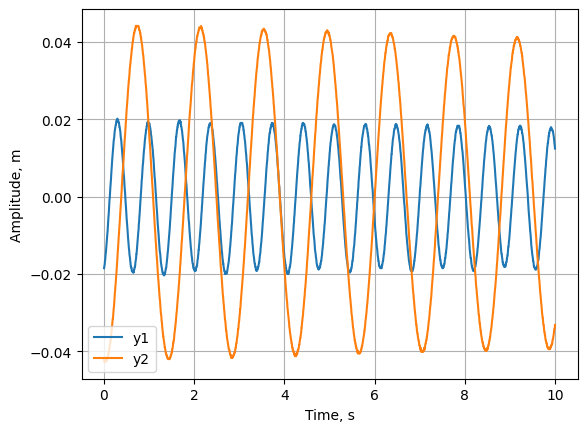

In [18]:
y1, y2 = rotate(x1, x2)

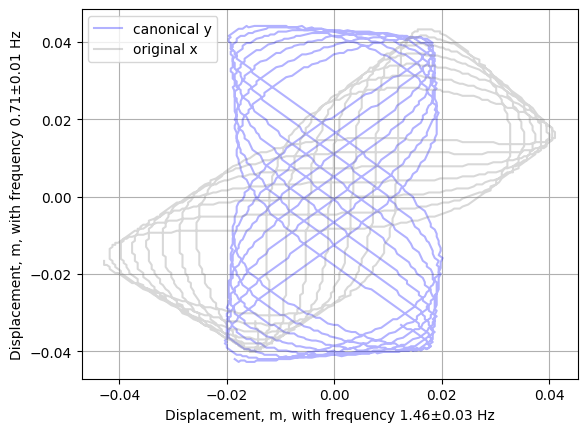

In [19]:
f1, f1u = get_frequency(t, y1)
f2, f2u = get_frequency(t, y2)

plt.plot(y1, y2, color='blue', alpha=0.3, label=f'canonical y')
plt.plot(x1, x2, color='gray', alpha=0.3, label='original x')

plt.grid()
plt.xlabel(f'Displacement, m, with frequency {f1:.2f}±{f1u:.2f} Hz')
plt.ylabel(f'Displacement, m, with frequency {f2:.2f}±{f2u:.2f} Hz')
plt.legend();

# Forced oscillations with friction






## Direct measurements

In [20]:
# Springs
l = 97.95e-3 # m, spring strain
g = 9.8 # m/s^2

# left spring (attached to cart A)
weightl = 44.8e-3 #
kl = weightl * g /l
ml = 17e-3 # kg

# right spring (attached to cart B)
weightr = 44.8e-3
kr = weightr * g /l
mr = 17e-3 # kg

# middle spring (between carts A and B)
weightc = 68.6e-3
kc = weightc * g /l
mc = 11.7e-3 #

# Carts (5A, 6B, 6C)
m1 = 208.9e-3 #kg
m2 = 213.8e-3
counts = 236
length = 123e-3

## Expected natural frequencies

In [21]:
m1_eff = m1 + ml/2 + mc/2
m2_eff = m2 + mc/2 + mr/2
a = np.array([[(kl+kc)/m1_eff, -kc/m1_eff],
              [-kc/m2_eff, (kc + kr)/m2_eff]])
eigenvalues, eigenvectors = LA.eig(a)
freqs_theor = np.sqrt(eigenvalues)/2/np.pi # Herz
freqs_theor

array([1.42966672, 0.70924425])

In [22]:
def get_signal3(url, show=True):
  data = np.loadtxt(url)
  _, t, a, b, c = data.T
  x1 = a/counts * length
  x2 = b/counts * length
  x3 = c/counts * length
  x1 -= x1.mean()
  x2 -= x2.mean()
  x3 -= x3.mean()
  if show:
    plt.plot(t, x1, label='Cart A')
    plt.plot(t, x2, label='Cart B')
    plt.plot(t, x3, label='Forced cart')
    plt.grid()
    plt.xlabel('Time, s')
    plt.ylabel('Amplitude, m')
    plt.ylim(-length/2, length/2)
    plt.legend()
  return t, x1, x2, x3




## Energy responce to forced oscillations

### Energy associated with main variables

$$
E_i \approx \frac{1}{2} m_i A_i^2 \omega_i^2
$$

In [23]:
def energy(t, oscillator, show=False):
  f0, f0_unc = get_frequency(t, oscillator)
  tpeaks, amplitude = get_amplitude(t, oscillator)
  omega0 = f0 * 2 * np.pi
  en = (amplitude * omega0)**2 /2
  if show:
    plt.plot(tpeaks, en )
    plt.grid()
    plt.xlabel('Time, s')
    plt.ylabel('Energy, (A omega)^2 /2')
  return np.mean(en)


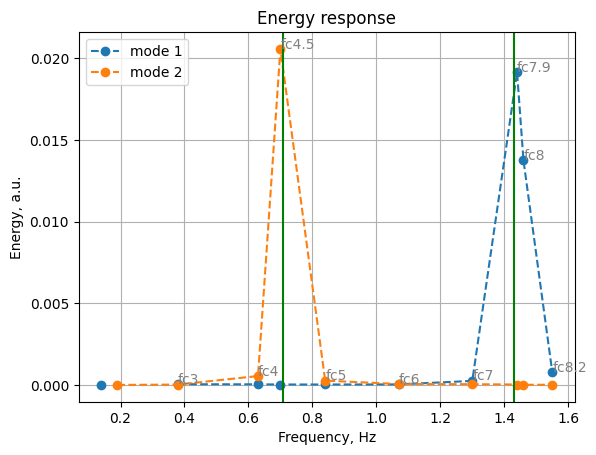

In [30]:
names = ['fc1', 'fc2', 'fc3', 'fc4', 'fc4.5','fc5', 'fc6', 'fc7', 'fc7.9',  'fc8.2', 'fc8']
fw = np.array([])
en1 = np.array([])
en2 = np.array([])
for name in names:
  url = f'https://raw.githubusercontent.com/evgeny-kolonsky/Lab3_Coupled_Oscillator/main/{name}.txt'
  t, x1, x2, x3 = get_signal3(url, show=False)
  y1, y2 = rotate(x1, x2, show=False) # to canonic variables
  fw = np.append(fw, get_frequency_fft(t, x3)) # get driver frequency
  en1 = np.append(en1, energy(t, y1)) # energy in 1st canonic var
  en2 = np.append(en2, energy(t, y2)) # energy in 2nd

idx = np.argsort(fw) # sorting
plt.plot(fw[idx], en1[idx], linestyle='--', marker='o', label='mode 1')
plt.plot(fw[idx], en2[idx], linestyle='--', marker='o', label='mode 2')
for ind in idx:
  plt.annotate(names[ind], xy=(fw[ind], en1[ind]+en2[ind]), color='gray')
plt.grid()
plt.xlabel('Frequency, Hz')
plt.ylabel('Energy, a.u.')
plt.title('Energy response')
for freq in freqs_theor:
  plt.axvline(freq, c='g')
  plt.annotate(fr'Natural ={freq:.2f}Hz',xy=(freq, np.mean(en1+en2)/2), color='gray')
plt.legend();

## Forced oscillations in resonance and out of resonance

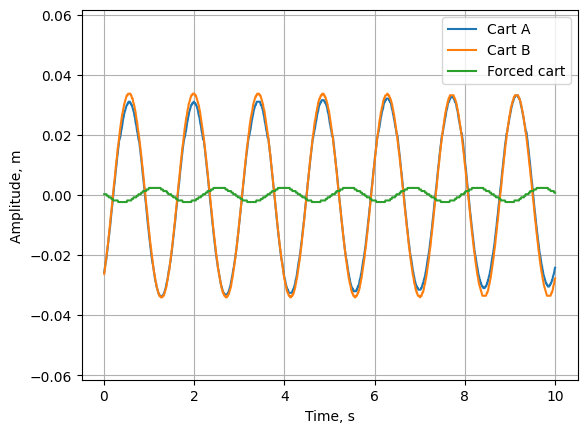

In [25]:
# Mode 1
url  = 'https://raw.githubusercontent.com/evgeny-kolonsky/Lab3_Coupled_Oscillator/main/fc4.5.txt'
t, x1, x2, x3 = get_signal3(url)

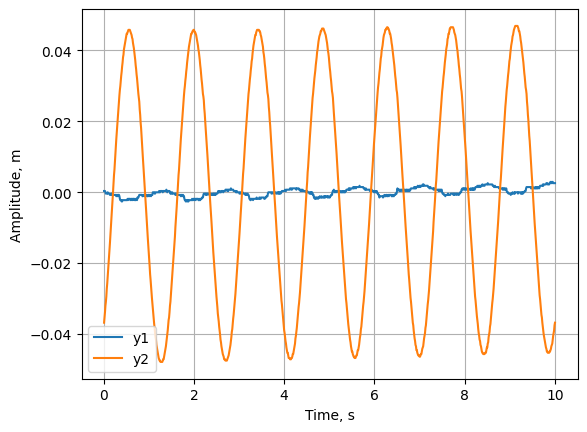

In [26]:
y1, y2 = rotate(x1, x2)

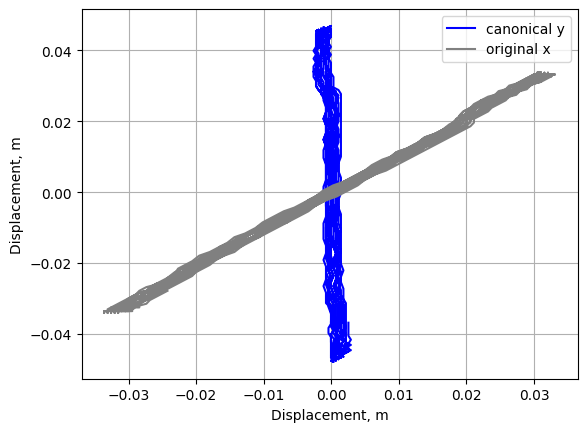

In [27]:
plt.plot(y1, y2, color='blue', label='canonical y')
plt.plot(x1, x2, color='gray', label='original x')
plt.grid()
plt.xlabel('Displacement, m')
plt.ylabel('Displacement, m')
plt.legend();

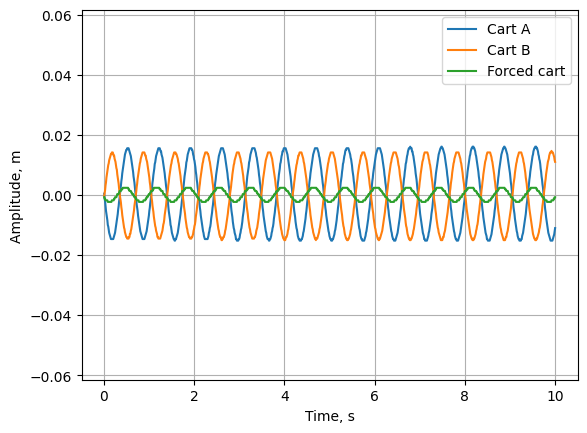

In [28]:
# Mode 2
url  = 'https://raw.githubusercontent.com/evgeny-kolonsky/Lab3_Coupled_Oscillator/main/fc7.9.txt'
t, x1, x2, x3 = get_signal3(url)

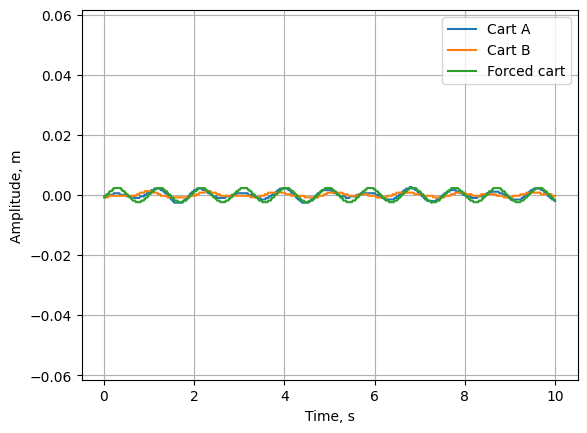

In [29]:
# No resonance
url  = 'https://raw.githubusercontent.com/evgeny-kolonsky/Lab3_Coupled_Oscillator/main/fc6.txt'
t, x1, x2, x3 = get_signal3(url)